In [9]:
import pandas as pd
import pyarrow.parquet as pq
from spark_hdfs import SparkHDFSConnector, SparkHDFSReader
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import concat, col, lit, sum, avg, when, count, date_format

root
 |-- Year: long (nullable = true)
 |-- Month: long (nullable = true)
 |-- DayofMonth: long (nullable = true)
 |-- FlightDate: timestamp_ntz (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelay: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- DistanceGroup: long (nullable = true)
 |-- CarrierDelay: double (nullable = true)
 |-- WeatherDelay: double (nullable = true)
 |-- NASDelay: double (nullable = true)
 |-- SecurityDel

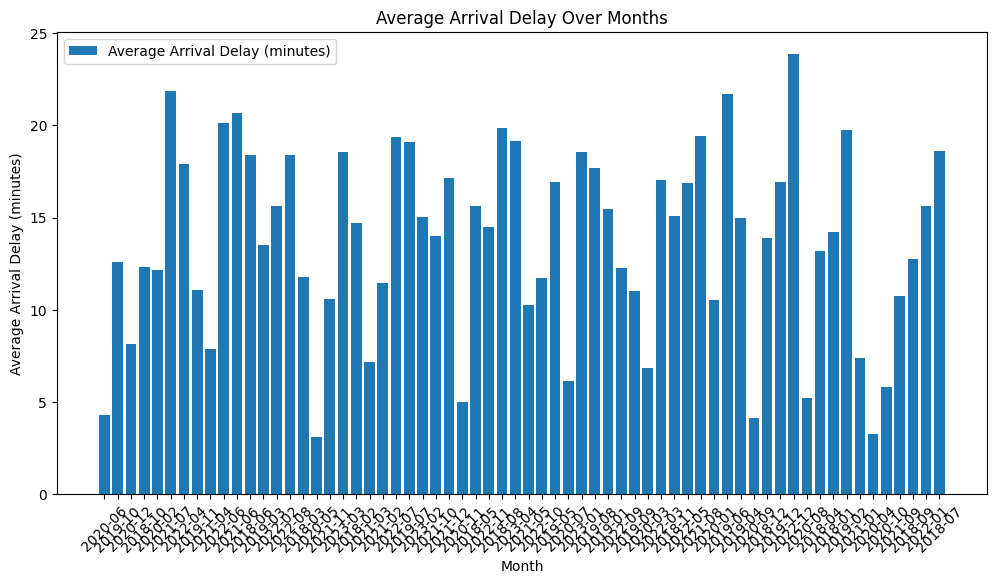

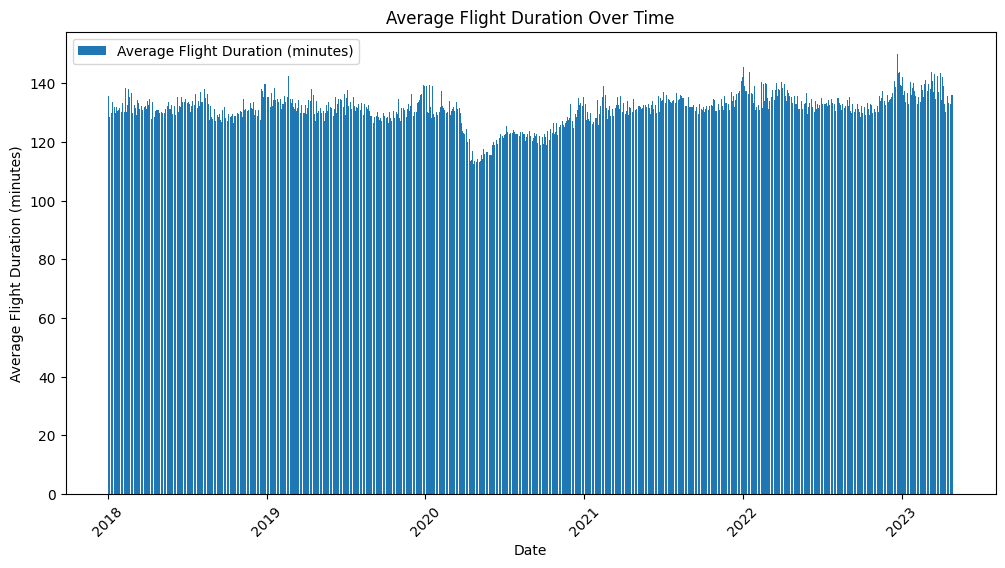

In [12]:
if __name__ == "__main__":
    hdfs_url = "http://localhost:9870"
    hdfs_user = "anna"
    spark_app_name = "ReadParquetKPIAppSpark"
    spark_master_url = "local[2]"  # Use Spark cluster's master URL if not running locally

    # Create an instance of the SparkHDFSConnector class
    connector = SparkHDFSConnector(hdfs_url, hdfs_user, spark_app_name, spark_master_url)

    # Define the Parquet file path
    parquet_file_path = "hdfs://localhost:9000/user/anna/flight_data/features_added.parquet"

    # Read and show the Parquet file using the connector
    df = connector.read_parquet_from_hdfs(parquet_file_path)

    # Stop the Spark session for the connector
    connector.stop_spark_session()

    # Create an instance of the SparkHDFSReader class
    hdfs_reader = SparkHDFSReader(hdfs_url, hdfs_user)

    # Create a Spark session for other operations
    hdfs_reader.create_spark_session(app_name="SessionKPICalApp")

    # Read and print the schema for the Parquet file using the reader
    df = hdfs_reader.read_parquet_file(parquet_file_path)

    #hdfs_reader.show_dataframe(df)
    hdfs_reader.print_schema(df)

    # Load the Parquet data
    parquet_data = hdfs_reader.read_parquet_file(parquet_file_path)

    # Handle missing values
    parquet_data = parquet_data.dropna(subset=["DepDelay", "CarrierDelay", "WeatherDelay", "SecurityDelay"])

    # Calculate TKPIs
    total_flights = parquet_data.count()
    on_time_flights = parquet_data.filter((col("DepDelay") <= 0) & (col("ArrDelay") <= 0)).count()
    otp = (on_time_flights / total_flights) * 100

    # Average Departure and Arrival Delays
    avg_dep_delay = parquet_data.select(avg("DepDelay")).first()[0]
    avg_arr_delay = parquet_data.select(avg("ArrDelay")).first()[0]

    # Average Flight Durations
    parquet_data = parquet_data.withColumn("FlightDuration", col("ArrTime") - col("DepTime"))
    avg_flight_duration = parquet_data.select(avg("FlightDuration")).first()[0]

    # Monitor KPIs Overtime
    # Group data by date and calculate KPIs for each day
    kpi_data_by_day = parquet_data.groupBy("FlightDate").agg(
        (sum(when(col("DepDelay") <= 0, 1).otherwise(0)) / count("*")).alias("OTP"),
        avg("DepDelay").alias("AvgDepDelay"),
        avg("ArrDelay").alias("AvgArrDelay"),
        avg("FlightDuration").alias("AvgFlightDuration")
    )

    # Visualize KPIs over time
    dates = kpi_data_by_day.select("FlightDate").collect()
    otp_values = kpi_data_by_day.select("OTP").collect()
    avg_dep_delay_values = kpi_data_by_day.select("AvgDepDelay").collect()
    avg_arr_delay_values = kpi_data_by_day.select("AvgArrDelay").collect()
    avg_flight_duration_values = kpi_data_by_day.select("AvgFlightDuration").collect()

    # Create line charts or bar charts to monitor KPIs over time
    # Group the data by month and calculate the average arrival delay per month
    parquet_data = parquet_data.withColumn('YearMonth', date_format('FlightDate', 'yyyy-MM'))
    avg_arrival_delay_by_month = parquet_data.groupBy('YearMonth').avg('ArrDelayMinutes')

    # Extract months and average arrival delay values
    months = [row.YearMonth for row in avg_arrival_delay_by_month.collect()]
    avg_arrival_delay_values = [row['avg(ArrDelayMinutes)'] for row in avg_arrival_delay_by_month.collect()]

    # Create a figure and specify the size
    plt.figure(figsize=(12, 6))

    # Create the bar chart for Average Arrival Delay over months
    plt.bar(months, avg_arrival_delay_values, label='Average Arrival Delay (minutes)')

    # Set chart title and labels
    plt.title('Average Arrival Delay Over Months')
    plt.xlabel('Month')
    plt.ylabel('Average Arrival Delay (minutes)')

    # Rotate x-axis labels for better readability (optional)
    plt.xticks(rotation=45)

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

    # Average Flight Duration Over Time
    # Group the data by 'FlightDate' and calculate the average flight duration per day
    avg_flight_duration_by_date = parquet_data.groupBy('FlightDate').avg('ActualElapsedTime')

    # Extract dates and average flight duration values
    dates = [row.FlightDate for row in avg_flight_duration_by_date.collect()]
    avg_flight_duration_values = [row['avg(ActualElapsedTime)'] for row in avg_flight_duration_by_date.collect()]

    # Create a figure and specify the size
    plt.figure(figsize=(12, 6))

    # Create the bar chart for Average Flight Duration over time
    plt.bar(dates, avg_flight_duration_values, label='Average Flight Duration (minutes)')

    # Set chart title and labels
    plt.title('Average Flight Duration Over Time')
    plt.xlabel('Date')
    plt.ylabel('Average Flight Duration (minutes)')

    # Rotate x-axis labels for better readability (optional)
    plt.xticks(rotation=45)

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

    # Close the Spark session for other operations
    hdfs_reader.close_spark_session()